<a href="https://colab.research.google.com/github/h4x4d/narod_parser/blob/main/narod_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variables:

In [ ]:
SITE_URL = "http://emery-emerald.narod.ru/Cpp/2E1562.html"

Selenium installation:

In [ ]:
%%shell
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

apt-get update
apt-get install chromium chromium-driver

pip install selenium

Executing: /tmp/apt-key-gpghome.IOyMdio2YX/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.6triaKb0NS/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.BRkz1IwTRM/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

Start selenium browser:

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')


driver = webdriver.Chrome(options=chrome_options)

Get html file with styles/attachments:

In [ ]:
import requests

resp = requests.get(SITE_URL)

In [ ]:
sources = SITE_URL[:SITE_URL.rfind('/')]
sources

'http://emery-emerald.narod.ru/Cpp'

In [ ]:
import re
from urllib.parse import urljoin

html = resp.text
absolutize = lambda m: ' src="' + urljoin(sources, m.group(1)) + '"'
html = re.sub(r' src="([^"]+)"', absolutize, html)
absolutize2 = lambda m: ' href="' + urljoin(sources, m.group(1)) + '"'
html = re.sub(r' href="([^"]+)"', absolutize2, html)

In [ ]:
html = html[:html.rfind('<!-- copyright (t2) -->')]

In [ ]:
open('with_styles.html', 'w').write(html)

55142

In [ ]:
import os

In [ ]:
abs_path = f'file://{os.getcwd()}/with_styles.html'
abs_path

'file:///content/with_styles.html'

In [ ]:
driver.get(abs_path)

True

In [ ]:
import io
from PIL import Image

temp = io.BytesIO(driver.get_screenshot_as_png())

image = Image.open(temp)
x, y = image.size
image = image.crop((0, 0, x - 15, y))
image.save('image_crop.png')

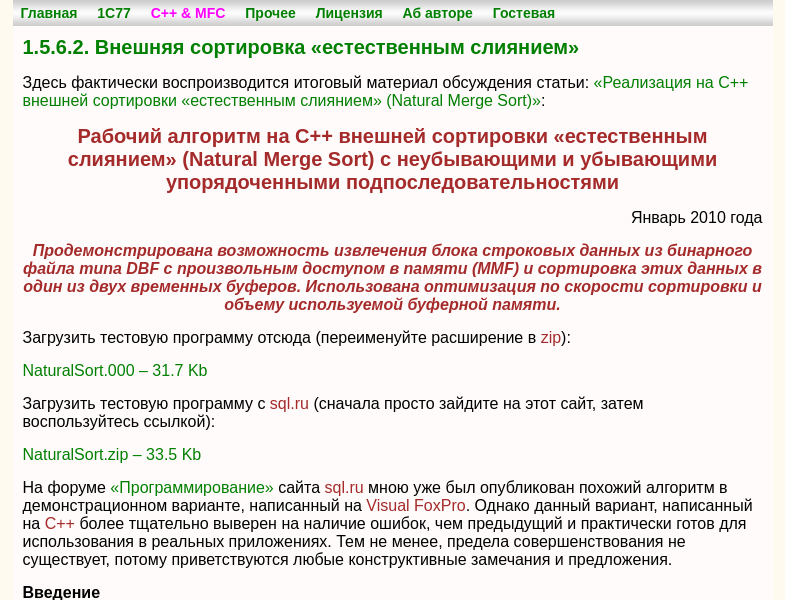

In [ ]:
from IPython.display import Image
Image('image_crop.png')

Get plain/markdown text:

In [ ]:
!pip install html2text

In [ ]:
import html2text

open('text.md', 'w').write(html2text.html2text(html))

42307

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)

open('text.txt', 'w').write(text)

32216

In [ ]:
driver.quit()